## Import Semua Packages/Library yang Digunakan

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, add, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Preparation

In [3]:
base_dir = 'dataset_asli'
classes = os.listdir(base_dir)
num_classes = len(classes)
split_base = 'dataset_split'

# Pengecekan: Jika folder 'dataset_split' sudah ada, lewati proses data preparation.
if not os.path.exists(split_base):
    print("Folder 'dataset_split' tidak ditemukan. Memulai proses data preparation...")
    
    # Membuat struktur folder untuk train, val, test
    train_dir = os.path.join(split_base, 'train')
    val_dir = os.path.join(split_base, 'val')
    test_dir = os.path.join(split_base, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    for cls in classes:
        # Buat folder per kelas di train, val, test
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
        
        # Ambil semua gambar di kelas tsb lalu diacak
        images = os.listdir(os.path.join(base_dir, cls))
        random.shuffle(images)
        total = len(images)
        
        # Hitung jumlah data
        train_count = int(0.6 * total)
        val_count = int(0.2 * total)
        test_count = total - train_count - val_count
        
        # Salin gambar sesuai bagiannya
        for i, img in enumerate(images):
            src = os.path.join(base_dir, cls, img)
            if i < train_count:
                dst = os.path.join(train_dir, cls, img)
            elif i < train_count + val_count:
                dst = os.path.join(val_dir, cls, img)
            else:
                dst = os.path.join(test_dir, cls, img)
            shutil.copy(src, dst)
    
    print("Proses data preparation selesai.")
else:
    print("Folder 'dataset_split' sudah ada. Melewati proses data preparation dan langsung ke data loading.")

Folder 'dataset_split' tidak ditemukan. Memulai proses data preparation...
Proses data preparation selesai.


# Data Loading

In [4]:
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 36000 images belonging to 10 classes.
Found 12000 images belonging to 10 classes.
Found 12000 images belonging to 10 classes.


# Modeling

In [5]:
def residual_block(x, filters, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', kernel_regularizer=regularizers.l2(1e-4))(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

def create_manual_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = create_manual_resnet(input_shape=(img_height, img_width, 3), num_classes=num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6, verbose=1)
]

steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size
if train_generator.samples % batch_size > 0:
    steps_per_epoch +=1
if val_generator.samples % batch_size > 0:
    validation_steps +=1

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
1125/1125 [==============================] - ETA: 0s - loss: 2.3150 - accuracy: 0.3532
Epoch 1: val_accuracy improved from -inf to 0.37392, saving model to best_model.keras
1125/1125 [==============================] - 1421s 1s/step - loss: 2.3150 - accuracy: 0.3532 - val_loss: 2.3467 - val_accuracy: 0.3739 - lr: 1.0000e-04
Epoch 2/50
1125/1125 [==============================] - ETA: 0s - loss: 1.8359 - accuracy: 0.4944
Epoch 2: val_accuracy improved from 0.37392 to 0.45042, saving model to best_model.keras
1125/1125 [==============================] - 328s 292ms/step - loss: 1.8359 - accuracy: 0.4944 - val_loss: 2.1542 - val_accuracy: 0.4504 - lr: 1.0000e-04
Epoch 3/50
1125/1125 [==============================] - ETA: 0s - loss: 1.6332 - accuracy: 0.5639
Epoch 3: val_accuracy improved from 0.45042 to 0.53300, saving model to best_model.keras
1125/1125 [==============================] - 329s 292ms/step - loss: 1.6332 - accuracy: 0.5639 - val_loss: 1.9211 - val_accuracy: 0.5330

# Evaluasi dan Visualisasi

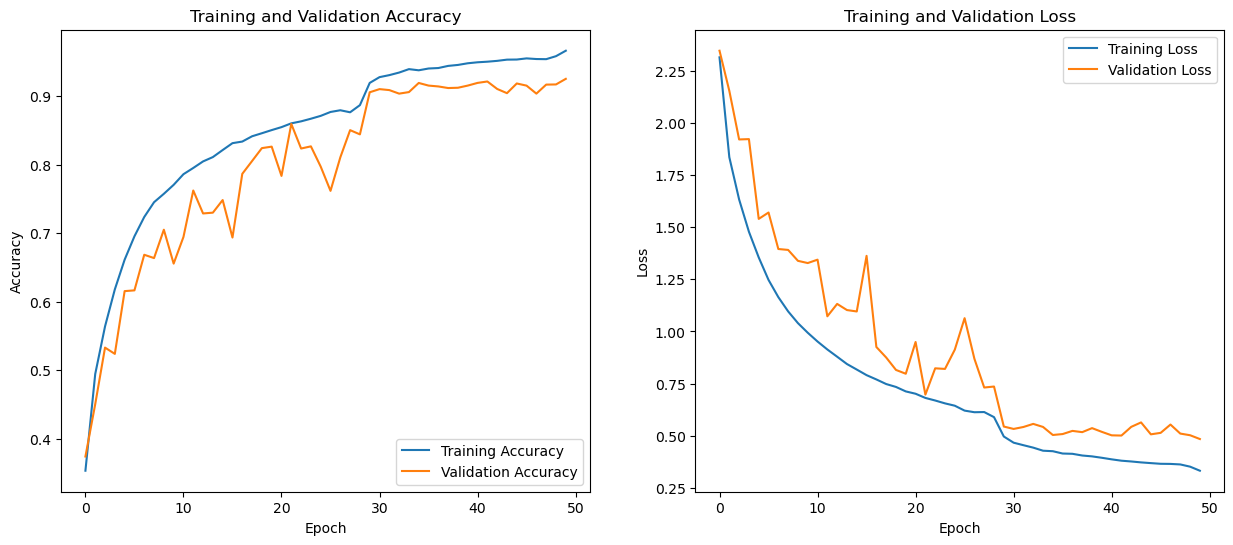


Evaluasi pada Training Set:
Training Accuracy: 97.82%
Training Loss: 0.2971

Evaluasi pada Validation Set:
Validation Accuracy: 92.55%
Validation Loss: 0.4840

Evaluasi pada Test Set:
Test Accuracy: 93.06%
Test Loss: 0.4573


In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print("\nEvaluasi pada Training Set:")
train_loss, train_acc = model.evaluate(train_generator, steps=steps_per_epoch, verbose=0)
print(f'Training Accuracy: {train_acc*100:.2f}%')
print(f'Training Loss: {train_loss:.4f}')

print("\nEvaluasi pada Validation Set:")
val_loss_eval, val_acc_eval = model.evaluate(val_generator, steps=validation_steps, verbose=0)
print(f'Validation Accuracy: {val_acc_eval*100:.2f}%')
print(f'Validation Loss: {val_loss_eval:.4f}')

print("\nEvaluasi pada Test Set:")
test_steps = test_generator.samples // batch_size
if test_generator.samples % batch_size > 0:
    test_steps +=1
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps, verbose=0)
print(f'Test Accuracy: {test_acc*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Konversi Model

In [8]:
saved_model_dir = 'saved_model'
if os.path.exists(saved_model_dir):
    shutil.rmtree(saved_model_dir)
model.save(saved_model_dir)
print(f"Model disimpan dalam format SavedModel di '{saved_model_dir}'")

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Model disimpan dalam format SavedModel di 'saved_model'


# Inference (Optional)

--- Inference Keras Model ---
1/1 [==============================] - 1s 996ms/step
Path gambar: sample.jpg
Predicted class (Keras): bird
Confidence: 89.69%


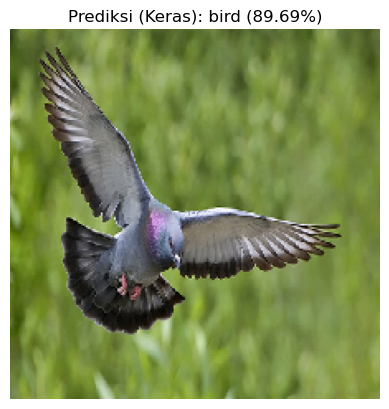

In [9]:
print("--- Inference Keras Model ---")
img_path_sample = 'sample.jpg'  # GANTI dengan path gambar uji Rino

if not os.path.exists(img_path_sample):
    print(f"File gambar contoh '{img_path_sample}' tidak ditemukan. Silakan unggah gambar contoh atau ganti path.")
else:
    img_keras = tf.keras.preprocessing.image.load_img(img_path_sample, target_size=(img_height, img_width))
    img_array_keras = tf.keras.preprocessing.image.img_to_array(img_keras)
    img_array_keras = np.expand_dims(img_array_keras, axis=0)
    img_array_keras_processed = img_array_keras / 255.0

    pred_keras = model.predict(img_array_keras_processed)
    class_idx_keras = np.argmax(pred_keras)
    class_labels = list(train_generator.class_indices.keys())

    print(f"Path gambar: {img_path_sample}")
    print(f"Predicted class (Keras): {class_labels[class_idx_keras]}")
    print(f"Confidence: {np.max(pred_keras)*100:.2f}%")

    plt.imshow(img_keras)
    plt.title(f"Prediksi (Keras): {class_labels[class_idx_keras]} ({np.max(pred_keras)*100:.2f}%)")
    plt.axis('off')
    plt.show()